## Import Required Packages

In [35]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler
import itertools

### Project Topic:

On April 15, 1912, during her maiden voyage the RMS Titanic sank after colliding with an iceberg resulting in the death of 1502 out of 2224 passengers and crew.

While there is some element of luck involved in surviving, there might be some groups of people were more likely to survive than others.

In this challenge, I'm trying to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Data Source:
The data for this assignment is downloaded from the following URL:
https://www.kaggle.com/competitions/titanic/data

* Only the train.csv from the URL is used since the other files don't contain the output variable

### Machine Learning Model:
The objective in this data is to predict which passengers survived the titanic disaster and as such it will be a **supervised logistic regression model**

In [2]:
df = pd.read_csv('titanic_data.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [130]:
# shape of the data
df.shape

(891, 12)

In [131]:
# feature information
# we can see that Age, Cabin and Embarked have null values in them
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Description:
There are 891 rows of data with 12 features:\
 \
    - PassengerId - fabricated column not to be used in the modelling process\
    - Survived - Contains ground truth labels indicating whether the passenger survived or not. Can take values 1 or 0\
    - Pclass - Ticket class of the passenger. Can take values 1, 2 or 3\
    - Name - Name of the passenger\
    - Sex - Gender of the passenger. Can take the string values male or female\
    - Age - Age of the passenger\
    - SibSp - Number of siblings / spouses aboard the Titanic\
    - Parch - Number of parents / children aboard the Titanic\
    - Ticket - Ticket number of the passenger\
    - Fare - Passenger fare\
    - Cabin - Cabin number\
    - Embarked - Port of Embarkation. Can take the values C = Cherbourg, Q = Queenstown or S = Southampton

In [132]:
# check for nulls in each column
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


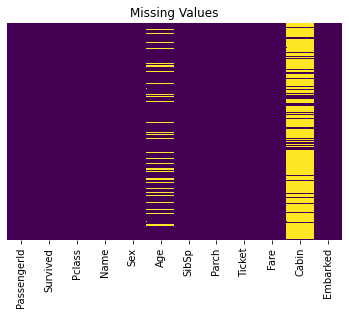

In [82]:
# Visualize missing values
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values')
plt.show()

## Data Cleaning and Imputing

* **checking correlation for identifying features to help in imputation**

In [83]:
df.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

* **to fill in nulls in Age, let's get the average value of age grouped by Pclass and Sex**
* **Pclass is chosen since it's the most correlated value with Age**
* **Sex is chosen since it's the most correlated with Survived**

In [3]:
df['Age'] = df['Age'].fillna(df.groupby(['Pclass', 'Sex'])['Age'].transform('mean'))

In [85]:
print('percentage of nulls in Cabin data: ', df['Cabin'].isna().sum() / df.shape[1])

percentage of nulls in Cabin data:  57.25


* **since almost 60% of the data for Cabin is null, we can drop this feature from the dataset**

In [4]:
df = df.drop('Cabin', axis=1)

* **Embarked only has 2 nulls. So we can fill nulls using the most popular value which is S**
* **also let's convert this into categorical variables so that it can be used for modelling**

In [5]:
df['Embarked'] = df['Embarked'].fillna('S')
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)

* **let's ignore PassengerId, Name and Ticket since they don't convey any direct information**

In [6]:
df = df.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

## EDA

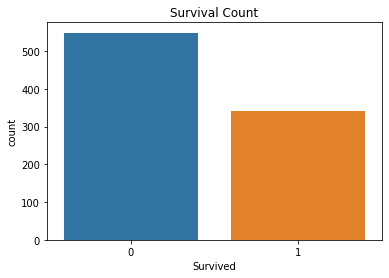

In [74]:
# Lets Explore the target variable
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')
plt.show()

* We can see that there is a good distribution for both 0 (62%) and 1 (38%)

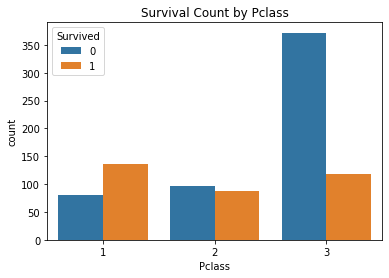

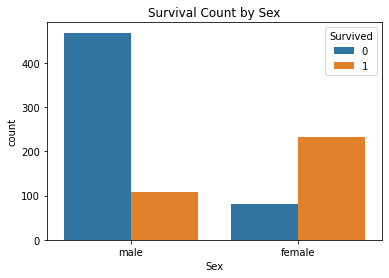

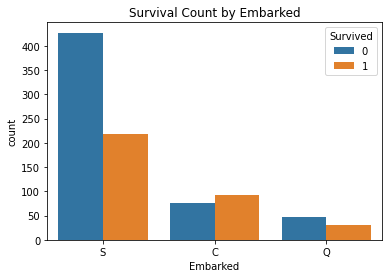

In [89]:
# Let's Explore categorical features
categorical_cols = ['Pclass', 'Sex', 'Embarked']
for col in categorical_cols:
    sns.countplot(x=col, hue='Survived', data=df)
    plt.title(f'Survival Count by {col}')
    plt.show()

* **Most observations are from Pclass 3, Sex Male and Embarked from Southampton**
* **Pclass 1 and 2 have more or almost the same amount of survivors when compared to people who didn't survive**
* **Women fare better when compared to men in terms of survival**
* **Passengers who embarked from S or C had a higher chance of survival**

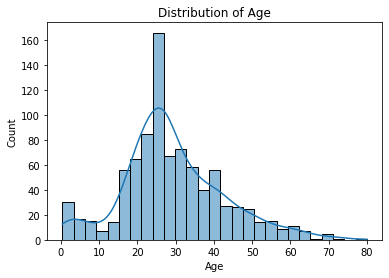

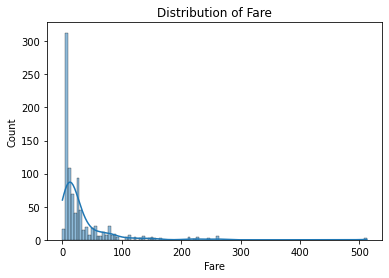

In [90]:
# Let's Explore numerical features
numerical_cols = ['Age', 'Fare']
for col in numerical_cols:
    sns.histplot(x=col, data=df, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

* **Age is distributed in an almost normal distribution**
* **Fare is highly skewed with a long right tail**

In [7]:
# sex can be converted to numerical by encoding male as 0 and female as 1
df['Sex'] = np.where(df['Sex'] == 'male', 0, 1)

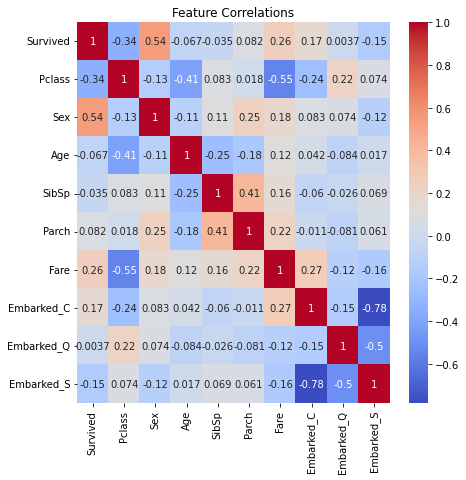

In [92]:
# Updated Feature correlations
corr = df.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Feature Correlations')
plt.show()

* **The most correlated feature with Survived is Sex. This makes sense given that 81% of men died and 74% of women survived**
* **Pclass, Fare and Embarked_C are the next highest correlated features. This is in line with the previous charts that we saw**

In [93]:
# Let's look for trends in the data
# Looking at the number of Parents and children features
df['Parch'].value_counts(normalize=True)

0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64

* **76% did not travel with parents or children**
* **therefore let's make a column indicating if they had any parent or children**

In [8]:
df['Parch_any'] = np.where(df['Parch'] > 0, 1, 0)

In [57]:
# Looking at the number of siblings and spouses features
df['SibSp'].value_counts(normalize=True)

0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64

* **Similarly 68% did not travel with Siblings or Spouses**
* **lets make a similar column for this**

In [9]:
df['SibSp_any'] = np.where(df['SibSp'] > 0, 1, 0)

* **We saw that the fare data was skewed and had a long right tail**
* **Therefore, let's cap the maximum value to reduce the skew**
* **Let's look at the boxplot to identify the IQR values**

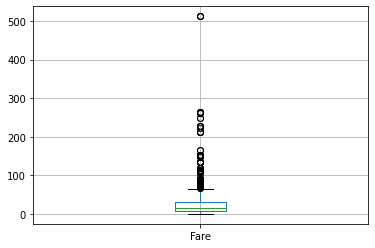

In [60]:
_ = df[['Fare']].boxplot()

* **looking at the data we can see that there are 53 entries with Fare greater than 100 out of which 39 survived**
* **since the survival rate is skewed in this sample, this can be a model feature**
* **we can also cap the data at 100**

In [10]:
df['Fare_100_plus'] = np.where(df['Fare'] >= 100, 1, 0)
df['Fare_capped'] = np.where(df['Fare_100_plus'] == 1, 100, df['Fare'])

<AxesSubplot:xlabel='Fare_capped', ylabel='Count'>

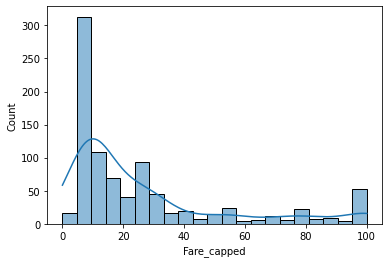

In [95]:
# The distribution is much better now
sns.histplot(df['Fare_capped'], kde=True)

## Model Building
### F1 Score (macro) will be the most important metric. Accuracy and AUC Score will be used as additional metrics

In [11]:
# creating an array with all features for future reference 
dv = 'Survived'
idvs = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare_capped',
        'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_100_plus',
        'Parch_any', 'SibSp_any']

all_comb = []
for i in range(1, len(idvs) + 1):
    all_comb = all_comb + list(itertools.combinations(idvs, i))
len(all_comb)

4095

* **Let's split the data into train and test**
* **I've decided to keep 20% of the data as test**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[idvs],
                                                    df[dv].values.ravel(), test_size=0.2, random_state=144)

###  Baseline model

#### Let's build a simple model which predicts survived if Sex is 1 since Sex is the most correlated feature

In [13]:
print('simple model train accuracy score: ', accuracy_score(y_train, np.where(X_train['Sex'] == 1, 1, 0)))
print('simple model test accuracy score: ', accuracy_score(y_test, np.where(X_test['Sex'] == 1, 1, 0)))
print('simple model train f1 score: ', f1_score(y_train, np.where(X_train['Sex'] == 1, 1, 0), average='macro'))
print('simple model test f1 score: ', f1_score(y_test, np.where(X_test['Sex'] == 1, 1, 0), average='macro'))
print('simple model train auc score: ', roc_auc_score(y_train, np.where(X_train['Sex'] == 1, 1, 0), average='macro'))
print('simple model test auc score: ', roc_auc_score(y_test, np.where(X_test['Sex'] == 1, 1, 0), average='macro'))

simple model train accuracy score:  0.7837078651685393
simple model test accuracy score:  0.7988826815642458
simple model train f1 score:  0.7674978795589482
simple model test f1 score:  0.7839903459372486
simple model train auc score:  0.7642309076151985
simple model test auc score:  0.7778429838288994


* **This model performs well across both train and test sets (in fact better on the test set)**
* **Let's aim to better this score**

### Logistic Models

* **Using all idvs**

In [14]:
lm = LogisticRegression(random_state=144, max_iter=330).fit(X_train, y_train)
train_pred = lm.predict(X_train)
test_pred = lm.predict(X_test)
print('logistic model train accuracy score: ', accuracy_score(y_train, train_pred))
print('logistic model test accuracy score: ', accuracy_score(y_test, test_pred))
print('logistic model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('logistic model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('logistic model train auc score: ', roc_auc_score(y_train, train_pred))
print('logistic model test auc score: ', roc_auc_score(y_test, test_pred))

logistic model train accuracy score:  0.8146067415730337
logistic model test accuracy score:  0.8268156424581006
logistic model train f1 score:  0.8003924866834875
logistic model test f1 score:  0.8121593717206594
logistic model train auc score:  0.7962865342939144
logistic model test auc score:  0.8034037558685445


* **Logistic model using all idvs performs better than the baseline model thus achieving our objective. Let's try to keep improving the score**

* **Logistic Model using select IDVs**

In [16]:
# identifying the features with the best test F1 Score
d = {}
for selected_columns in all_comb:
    lm = LogisticRegression(random_state=144, max_iter=330).fit(X_train[list(selected_columns)], y_train)
    test_pred = lm.predict(X_test[list(selected_columns)])
    d[selected_columns] = f1_score(y_test, test_pred, average='macro')
dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

c:\users\dhria\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\dhria\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

{('Pclass',
  'Sex',
  'SibSp',
  'Fare_capped',
  'Embarked_C',
  'Fare_100_plus',
  'SibSp_any'): 0.8265329991645781,
 ('Pclass',
  'Sex',
  'SibSp',
  'Fare_capped',
  'Embarked_C',
  'Embarked_Q',
  'Fare_100_plus',
  'SibSp_any'): 0.8265329991645781,
 ('Pclass',
  'Sex',
  'SibSp',
  'Fare_capped',
  'Embarked_S',
  'Fare_100_plus',
  'SibSp_any'): 0.8210954157782515,
 ('Pclass',
  'Sex',
  'SibSp',
  'Parch',
  'Fare_capped',
  'Embarked_C',
  'Fare_100_plus',
  'SibSp_any'): 0.8210954157782515,
 ('Pclass',
  'Sex',
  'SibSp',
  'Parch',
  'Fare_capped',
  'Embarked_S',
  'Fare_100_plus',
  'SibSp_any'): 0.8210954157782515,
 ('Pclass',
  'Sex',
  'SibSp',
  'Fare_capped',
  'Embarked_C',
  'Embarked_S',
  'Fare_100_plus',
  'SibSp_any'): 0.8210954157782515,
 ('Pclass',
  'Sex',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Embarked_S',
  'Fare_100_plus',
  'SibSp_any'): 0.8210954157782515,
 ('Pclass',
  'Sex',
  'SibSp',
  'Parch',
  'Fare_capped',
  'Embarked_C',
  'Embarked_Q'

In [17]:
selected_columns = ['Pclass', 'Sex', 'SibSp', 'Fare_capped', 'Embarked_C', 'Fare_100_plus', 'SibSp_any']
lm = LogisticRegression(random_state=144, max_iter=330).fit(X_train[selected_columns], y_train)
train_pred = lm.predict(X_train[selected_columns])
test_pred = lm.predict(X_test[selected_columns])
print('logistic model train accuracy score: ', accuracy_score(y_train, train_pred))
print('logistic model test accuracy score: ', accuracy_score(y_test, test_pred))
print('logistic model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('logistic model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('logistic model train auc score: ', roc_auc_score(y_train, train_pred))
print('logistic model test auc score: ', roc_auc_score(y_test, test_pred))

logistic model train accuracy score:  0.7921348314606742
logistic model test accuracy score:  0.8379888268156425
logistic model train f1 score:  0.7758339006126617
logistic model test f1 score:  0.8265329991645781
logistic model train auc score:  0.771744860305746
logistic model test auc score:  0.8199008868022952


* **Using the selected features results in the best scores across the board**

* **Checking coef values**

In [18]:
{var: coef for var, coef in zip(idvs, lm.coef_[0])}

{'Pclass': -0.6257633525712163,
 'Sex': 2.5139372342939934,
 'Age': -0.5906517677832964,
 'SibSp': 0.009212084735291722,
 'Parch': 0.3388283064390225,
 'Fare_capped': -0.32347102767519215,
 'Embarked_C': 0.7763637441455029}

* **Among categorical variables, Sex is the most important and Embarked_C is the least important**

##  Decision Tree Model
#### Using all IDVs

In [19]:
dtc = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 4],
          'min_samples_split': [20, 50], 'min_samples_leaf': [5, 10],
          'class_weight': [None, 'balanced'],
          'ccp_alpha': [0, 1, 5], 'random_state': [144]}
grid = GridSearchCV(dtc, param_grid=params, cv=3,
                    scoring='f1_macro', return_train_score=True).fit(X_train, y_train)

In [20]:
# best params for train data
grid.best_params_, grid.best_score_

({'ccp_alpha': 0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 5,
  'min_samples_split': 20,
  'random_state': 144},
 0.7956843139782269)

In [21]:
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train, y_train)
train_pred = dtc.predict(X_train)
test_pred = dtc.predict(X_test)
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.827247191011236
Decision_Tree model test accuracy score:  0.8268156424581006
Decision_Tree model train f1 score:  0.8132385337339711
Decision_Tree model test f1 score:  0.8108531888059447
Decision_Tree model train auc score:  0.8079130791307914
Decision_Tree model test auc score:  0.8009911319770475


### Identifying the best features for the grid values

In [22]:
# identifying the features with the best test F1 Score using the best grid values
d = {}
for selected_columns in all_comb:
    dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train[list(selected_columns)], y_train)
    test_pred = dtc.predict(X_test[list(selected_columns)])
    d[selected_columns] = f1_score(y_test, test_pred, average='macro')
dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

{('Pclass', 'Sex', 'Age', 'Fare_capped'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'SibSp', 'Fare_capped'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Parch', 'Fare_capped'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Fare_capped', 'Embarked_C'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Fare_capped', 'Embarked_Q'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Fare_capped', 'Embarked_S'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Fare_capped', 'Fare_100_plus'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Fare_capped', 'Parch_any'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'Fare_capped', 'SibSp_any'): 0.8108531888059447,
 ('Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare_capped'): 0.8108531888059447,
 ('Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_C'): 0.8108531888059447,
 ('Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q'): 0.8108531888059447,
 ('Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked

In [23]:
selected_features = ['Pclass', 'Sex', 'Age', 'Fare_capped']
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train[selected_features], y_train)
train_pred = dtc.predict(X_train[selected_features])
test_pred = dtc.predict(X_test[selected_features])
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.8202247191011236
Decision_Tree model test accuracy score:  0.8268156424581006
Decision_Tree model train f1 score:  0.8048245614035088
Decision_Tree model test f1 score:  0.8108531888059447
Decision_Tree model train auc score:  0.7986879868798687
Decision_Tree model test auc score:  0.8009911319770475


### Trying to find out best params again using top features

In [24]:
selected_features = ['Pclass', 'Sex', 'Age', 'Fare_capped']
dtc = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 4],
          'min_samples_split': [20, 50], 'min_samples_leaf': [5, 10],
          'class_weight': [None, 'balanced'],
          'ccp_alpha': [0, 1, 5], 'random_state': [144]}
grid = GridSearchCV(dtc, param_grid=params, cv=3,
                    scoring='f1_macro', return_train_score=True).fit(X_train[selected_features], y_train)
# best params for train data
grid.best_params_, grid.best_score_

({'ccp_alpha': 0,
  'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 4,
  'min_samples_leaf': 10,
  'min_samples_split': 20,
  'random_state': 144},
 0.7967412937873969)

In [25]:
# Best model with selected features and params
dtc = DecisionTreeClassifier(**grid.best_params_).fit(X_train[selected_features], y_train)
train_pred = dtc.predict(X_train[selected_features])
test_pred = dtc.predict(X_test[selected_features])
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.8384831460674157
Decision_Tree model test accuracy score:  0.8268156424581006
Decision_Tree model train f1 score:  0.823570605156272
Decision_Tree model test f1 score:  0.8094763948497854
Decision_Tree model train auc score:  0.8155609107111479
Decision_Tree model test auc score:  0.7985785080855504


### The third Decision Tree gives the best overall scores. Only the test F1 score is lower than logistic model score

### Top Model Features

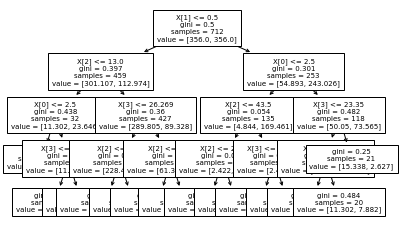

In [40]:
_ = plot_tree(dtc, fontsize=7)

In [48]:
{j:i for i,j in zip(dtc.feature_importances_, ['Pclass', 'Sex', 'Age', 'Fare_capped'])}

{'Pclass': 0.14833088957758817,
 'Sex': 0.5889942957551222,
 'Age': 0.11656700333627992,
 'Fare_capped': 0.14610781133100967}

* **As expected Sex is the most important feature followed by PClass**

## Random Forest Models

#### Grid Search with all IDVs

In [26]:
rfc = RandomForestClassifier()
params = {'n_estimators': [30, 50, 100], 'random_state': [144],
          'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced', 'balanced_subsample'],
          'ccp_alpha': [0, 1, 5], 'max_samples': [1, 0.9, 0.8],
          'max_depth': [3, 4], 'min_samples_split': [15, 20, 50],
          'min_samples_leaf': [3, 5, 10]}

grid = GridSearchCV(rfc, param_grid=params, cv=3,
                    scoring='f1_macro', return_train_score=True).fit(X_train, y_train)

# best params for train data
grid.best_params_, grid.best_score_

({'ccp_alpha': 0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': 4,
  'max_samples': 0.9,
  'min_samples_leaf': 3,
  'min_samples_split': 15,
  'n_estimators': 100,
  'random_state': 144},
 0.7962792097380191)

In [27]:
rfc = RandomForestClassifier(**grid.best_params_).fit(X_train, y_train)
train_pred = rfc.predict(X_train)
test_pred = rfc.predict(X_test)
print('Random_Forest model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Random_Forest model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Random_Forest model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Random_Forest model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Random_Forest model train auc score: ', roc_auc_score(y_train, train_pred))
print('Random_Forest model test auc score: ', roc_auc_score(y_test, test_pred))

Random_Forest model train accuracy score:  0.8398876404494382
Random_Forest model test accuracy score:  0.8100558659217877
Random_Forest model train f1 score:  0.8189749765823631
Random_Forest model test f1 score:  0.7850988700564971
Random_Forest model train auc score:  0.8046037603233175
Random_Forest model test auc score:  0.7726264997391759


### Identifying the best features for the grid values

In [28]:
# identifying the features with the best test F1 Score using the best grid values
d = {}
for selected_columns in all_comb:
    rfc = RandomForestClassifier(**grid.best_params_).fit(X_train[list(selected_columns)], y_train)
    test_pred = rfc.predict(X_test[list(selected_columns)])
    d[selected_columns] = f1_score(y_test, test_pred, average='macro')
dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

{('Sex', 'Age', 'SibSp', 'Parch'): 0.8175951086956521,
 ('Sex', 'Age', 'SibSp', 'Parch', 'Embarked_Q'): 0.8175951086956521,
 ('Sex', 'Age', 'SibSp', 'Parch', 'Parch_any'): 0.8175951086956521,
 ('Sex', 'Age', 'SibSp', 'Parch', 'SibSp_any'): 0.8175951086956521,
 ('Sex',
  'Age',
  'SibSp',
  'Parch',
  'Embarked_Q',
  'Embarked_S'): 0.8175951086956521,
 ('Sex',
  'Age',
  'SibSp',
  'Parch',
  'Embarked_Q',
  'Parch_any'): 0.8175951086956521,
 ('Sex',
  'Age',
  'SibSp',
  'Parch',
  'Parch_any',
  'SibSp_any'): 0.8175951086956521,
 ('Sex',
  'Age',
  'SibSp',
  'Parch',
  'Embarked_Q',
  'Embarked_S',
  'SibSp_any'): 0.8175951086956521,
 ('Sex',
  'Age',
  'SibSp',
  'Parch',
  'Embarked_Q',
  'Parch_any',
  'SibSp_any'): 0.8175951086956521,
 ('Sex',
  'Age',
  'SibSp',
  'Parch',
  'Embarked_S',
  'Parch_any',
  'SibSp_any'): 0.8175951086956521,
 ('Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Parch_any',
  'SibSp_any'): 0.8134898582939706,
 ('Pclass',
  'Sex',
  'Age',
  'SibSp',
  'Parch'

In [29]:
selected_features = ['Sex', 'Age', 'SibSp', 'Parch']
rfc = RandomForestClassifier(**grid.best_params_).fit(X_train[selected_features], y_train)
train_pred = rfc.predict(X_train[selected_features])
test_pred = rfc.predict(X_test[selected_features])
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.8258426966292135
Decision_Tree model test accuracy score:  0.8324022346368715
Decision_Tree model train f1 score:  0.8124899117329731
Decision_Tree model test f1 score:  0.8175951086956521
Decision_Tree model train auc score:  0.8082017554869425
Decision_Tree model test auc score:  0.8080333854981742


### Trying to find out best params again using top features

In [31]:
selected_features = ['Sex', 'Age', 'SibSp', 'Parch']
rfc = RandomForestClassifier()
params = {'n_estimators': [30, 50, 100], 'random_state': [144],
          'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced', 'balanced_subsample'],
          'ccp_alpha': [0, 1, 5], 'max_samples': [1, 0.9, 0.8],
          'max_depth': [3, 4], 'min_samples_split': [15, 20, 50],
          'min_samples_leaf': [3, 5, 10]}
grid = GridSearchCV(rfc, param_grid=params, cv=3,
                    scoring='f1_macro', return_train_score=True).fit(X_train[selected_features], y_train)
# best params for train data
grid.best_params_, grid.best_score_

({'ccp_alpha': 0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': 4,
  'max_samples': 0.8,
  'min_samples_leaf': 5,
  'min_samples_split': 15,
  'n_estimators': 100,
  'random_state': 144},
 0.8053814356999177)

In [32]:
# Best model with selected features and params
rfc = RandomForestClassifier(**grid.best_params_).fit(X_train[selected_features], y_train)
train_pred = rfc.predict(X_train[selected_features])
test_pred = rfc.predict(X_test[selected_features])
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.8188202247191011
Decision_Tree model test accuracy score:  0.8212290502793296
Decision_Tree model train f1 score:  0.805396472270777
Decision_Tree model test f1 score:  0.8067476383265857
Decision_Tree model train auc score:  0.8018215896444678
Decision_Tree model test auc score:  0.798774126238915


### Top Model Features

In [53]:
# Recreating the second model since that was the best one
selected_features = ['Sex', 'Age', 'SibSp', 'Parch']
best_grid_params = {'ccp_alpha': 0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': 4,
  'max_samples': 0.9,
  'min_samples_leaf': 3,
  'min_samples_split': 15,
  'n_estimators': 100,
  'random_state': 144}
rfc = RandomForestClassifier(**best_grid_params).fit(X_train[selected_features], y_train)

In [54]:
{j:i for i,j in zip(rfc.feature_importances_, ['Sex', 'Age', 'SibSp', 'Parch'])}

{'Sex': 0.657930803939074,
 'Age': 0.17315951725779996,
 'SibSp': 0.10294237648163222,
 'Parch': 0.0659673023214937}

* **Sex is the most important feature followed by Age**

## Gradient Boosting

In [55]:
gbc = GradientBoostingClassifier()
params = {'loss': ['exponential'], 'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [5, 10, 15], 'subsample': [1, 0.9], 'min_samples_split': [15, 20, 50], 
          'min_samples_leaf': [3, 5, 10], 'max_depth': [3, 4], 'random_state': [144],
          'ccp_alpha': [0, 1, 2]}

grid = GridSearchCV(gbc, param_grid=params, cv=3,
                    scoring='f1_macro', return_train_score=True).fit(X_train, y_train)

# best params for train data
grid.best_params_, grid.best_score_

({'ccp_alpha': 0,
  'learning_rate': 0.1,
  'loss': 'exponential',
  'max_depth': 4,
  'min_samples_leaf': 3,
  'min_samples_split': 15,
  'n_estimators': 15,
  'random_state': 144,
  'subsample': 1},
 0.8060651467799316)

In [56]:
gbc = GradientBoostingClassifier(**grid.best_params_).fit(X_train, y_train)
train_pred = gbc.predict(X_train)
test_pred = gbc.predict(X_test)
print('Gradient_Boosting model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Gradient_Boosting model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Gradient_Boosting model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Gradient_Boosting model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Gradient_Boosting model train auc score: ', roc_auc_score(y_train, train_pred))
print('Gradient_Boosting model test auc score: ', roc_auc_score(y_test, test_pred))

Gradient_Boosting model train accuracy score:  0.8539325842696629
Gradient_Boosting model test accuracy score:  0.8324022346368715
Gradient_Boosting model train f1 score:  0.8362451015949119
Gradient_Boosting model test f1 score:  0.8119747899159664
Gradient_Boosting model train auc score:  0.8223427132230506
Gradient_Boosting model test auc score:  0.7983828899321858


### Identifying the best features for the grid values

In [57]:
# identifying the features with the best test F1 Score using the best grid values
d = {}
for selected_columns in all_comb:
    gbc = GradientBoostingClassifier(**grid.best_params_).fit(X_train[list(selected_columns)], y_train)
    test_pred = gbc.predict(X_test[list(selected_columns)])
    d[selected_columns] = f1_score(y_test, test_pred, average='macro')
dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

{('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Parch_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Embarked_S',
  'Parch_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Fare_100_plus',
  'Parch_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Parch_any',
  'SibSp_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Embarked_S',
  'Fare_100_plus',
  'Parch_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Embarked_S',
  'Parch_any',
  'SibSp_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Fare_100_plus',
  'Parch_any',
  'SibSp_any'): 0.819991954947707,
 ('Sex',
  'Age',
  'SibSp',
  'Fare_capped',
  'Embarked_Q',
  'Embarked_S',
  'Fare_100_plus',
  'Parch_any',
  'SibSp_any'): 0.819991954947707,
 ('Pclass',
  'Sex',
  '

In [58]:
selected_features = ['Sex', 'Age', 'SibSp', 'Fare_capped', 'Embarked_Q', 'Parch_any']
gbc = GradientBoostingClassifier(**grid.best_params_).fit(X_train[selected_features], y_train)
train_pred = gbc.predict(X_train[selected_features])
test_pred = gbc.predict(X_test[selected_features])
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.8314606741573034
Decision_Tree model test accuracy score:  0.8324022346368715
Decision_Tree model train f1 score:  0.818538624257716
Decision_Tree model test f1 score:  0.819991954947707
Decision_Tree model train auc score:  0.8141593660834567
Decision_Tree model test auc score:  0.8128586332811685


### Trying to find out best params again using top features

In [59]:
selected_features = ['Sex', 'Age', 'SibSp', 'Fare_capped', 'Embarked_Q', 'Parch_any']
gbc = GradientBoostingClassifier()
params = {'loss': ['exponential'], 'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [5, 10, 15], 'subsample': [1, 0.9], 'min_samples_split': [15, 20, 50], 
          'min_samples_leaf': [3, 5, 10], 'max_depth': [3, 4], 'random_state': [144],
          'ccp_alpha': [0, 1, 2]}
grid = GridSearchCV(gbc, param_grid=params, cv=3,
                    scoring='f1_macro', return_train_score=True).fit(X_train[selected_features], y_train)
# best params for train data
grid.best_params_, grid.best_score_

({'ccp_alpha': 0,
  'learning_rate': 0.1,
  'loss': 'exponential',
  'max_depth': 4,
  'min_samples_leaf': 10,
  'min_samples_split': 50,
  'n_estimators': 15,
  'random_state': 144,
  'subsample': 0.9},
 0.8004755258486025)

In [60]:
# Best model with selected features and params
gbc = GradientBoostingClassifier(**grid.best_params_).fit(X_train[selected_features], y_train)
train_pred = gbc.predict(X_train[selected_features])
test_pred = gbc.predict(X_test[selected_features])
print('Decision_Tree model train accuracy score: ', accuracy_score(y_train, train_pred))
print('Decision_Tree model test accuracy score: ', accuracy_score(y_test, test_pred))
print('Decision_Tree model train f1 score: ', f1_score(y_train, train_pred, average='macro'))
print('Decision_Tree model test f1 score: ', f1_score(y_test, test_pred, average='macro'))
print('Decision_Tree model train auc score: ', roc_auc_score(y_train, train_pred))
print('Decision_Tree model test auc score: ', roc_auc_score(y_test, test_pred))

Decision_Tree model train accuracy score:  0.8328651685393258
Decision_Tree model test accuracy score:  0.8100558659217877
Decision_Tree model train f1 score:  0.8183918738465692
Decision_Tree model test f1 score:  0.7946693657219973
Decision_Tree model train auc score:  0.8117369949209696
Decision_Tree model test auc score:  0.7871022430881585


### Top Model Features

In [62]:
# Recreating the second model since that was the best one
selected_features = ['Sex', 'Age', 'SibSp', 'Fare_capped', 'Embarked_Q', 'Parch_any']
best_grid_params = {'ccp_alpha': 0,
  'learning_rate': 0.1,
  'loss': 'exponential',
  'max_depth': 4,
  'min_samples_leaf': 3,
  'min_samples_split': 15,
  'n_estimators': 15,
  'random_state': 144,
  'subsample': 1}
gbc = GradientBoostingClassifier(**best_grid_params).fit(X_train[selected_features], y_train)

Decision_Tree model train accuracy score:  0.8314606741573034
Decision_Tree model test accuracy score:  0.8324022346368715
Decision_Tree model train f1 score:  0.818538624257716
Decision_Tree model test f1 score:  0.819991954947707
Decision_Tree model train auc score:  0.8141593660834567
Decision_Tree model test auc score:  0.8128586332811685


In [63]:
{j:i for i,j in zip(gbc.feature_importances_, ['Sex', 'Age', 'SibSp', 'Fare_capped', 'Embarked_Q', 'Parch_any'])}

{'Sex': 0.5875910635752994,
 'Age': 0.1005068520277309,
 'SibSp': 0.13250030476603614,
 'Fare_capped': 0.16972107610385379,
 'Embarked_Q': 0.00485340063431667,
 'Parch_any': 0.004827302892762762}

* **Sex is the most important feature followed by Fare_capped**

## Conclusion

* **The second iteration of the gradient boosting model gave the best overall performance and will be selected as the best model**
* **We were able to improve our F1 score from the baseline model 6%**
* **Overall we built more than 32000 models - using grid search, cross validation and feature selection to predict whether passengers would have survived the titanic disaster based on the features described**
* **Multiple data cleaning and EDA methods were employed to identify the best model data**